In [1]:
# load the dataset
import pandas as pd
import numpy as np
import os

signals = []

for file in os.listdir('intertial_signals'):
    data = pd.read_csv(os.path.join('intertial_signals', file), sep=r"\s+", header=None)
    signals.append(data)

data = np.stack(signals, axis=-1)
y = pd.read_csv('y_train.txt', sep=r"\s+", header=None).squeeze()
subjects = pd.read_csv('subject_train.txt', sep=r"\s+", header=None).squeeze()

In [16]:
# subject disjoint split

unique = np.unique(subjects)
np.random.seed(42)

train_subjects = np.random.choice(unique, size=int(0.8 * len(unique)), replace=False)
val_subjects = np.setdiff1d(unique, train_subjects)

train_mask = np.isin(subjects, train_subjects)
val_mask = np.isin(subjects, val_subjects)

X_train = data[train_mask]
y_train = y[train_mask]

X_val = data[val_mask]
y_val = y[val_mask]

# normalize X_train and X_val
mean = X_train.mean(axis=(0, 1), keepdims=True)
std = X_train.std(axis=(0, 1), keepdims=True) + 1
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std

overlap = set(train_subjects).intersection(set(val_subjects))
print("Overlap count:", len(overlap))

Overlap count: 0


In [17]:
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss

# Reshape data for MLP
n_samples, n_timesteps, n_features = X_train.shape
X_train_r = X_train.reshape(n_samples, n_timesteps * n_features)

n_samples_val, n_timesteps_val, n_features_val = X_val.shape
X_val_r = X_val.reshape(n_samples_val, n_timesteps_val * n_features_val)

mlp = MLPClassifier(hidden_layer_sizes=(32,), max_iter=1, random_state=42, warm_start=True)
epochs = 30
train_losses = []
val_losses = []
for i in range(epochs):
    mlp.fit(X_train_r, y_train)

    # training loss (already computed during fit)
    train_losses.append(mlp.loss_)

    # validation log loss (stable)
    val_proba = mlp.predict_proba(X_val_r)
    val_losses.append(log_loss(y_val, val_proba))  # handles clipping internally

C:\Users\taylon4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\taylon4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\taylon4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\taylon4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the opti

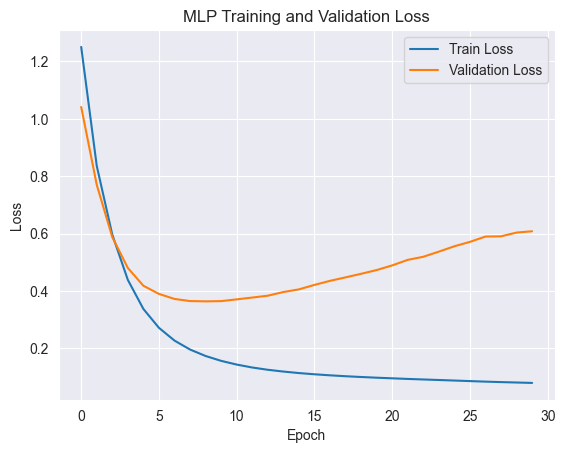

In [18]:
# plot train/val loss curves
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLP Training and Validation Loss')
plt.legend()
plt.show()